<a href="https://colab.research.google.com/github/ArielKatzir/LLM_EncoderDecoder_Translator_PyTorch/blob/master/LLM_Improved_encoder_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Small Scale Encoder Decoder LLM Translating English to Italian
### Improvements to the basic code


In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install sacrebleu

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.8 MB/s eta 0:00:00


In [2]:
import math
import random
import sacrebleu
import torch
import time

import numpy as np
import pandas as pd
import sentencepiece as spm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


# data downloaded from https://tatoeba.org/en/downloads
raw_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/english_italian.tsv', sep='\t', on_bad_lines='skip')
raw_df.shape, raw_df.head(1)

((681865, 4),
    1276    Let's try something.  565618      Proviamo qualcosa!
 0  1277  I have to go to sleep.  4369.0  Devo andare a dormire.)

In [3]:
t_english = np.array(raw_df[raw_df.columns[1]])
t_italian = np.array(raw_df[raw_df.columns[3]])

mask = np.random.rand(t_english.shape[0]) > 0.95

masked_indices = np.where(mask)[0]
assert len(t_english) == len(t_italian), "Mismatched lengths!"

t_eng_sample = t_english[masked_indices][:100000]
t_ita_sample = t_italian[masked_indices][:100000]

t_eng_sample.shape, t_ita_sample.shape

((33841,), (33841,))

In [4]:
with open("english_italian_tokanizer.txt", "w", encoding="utf-8") as f:
    for en, it in zip(t_eng_sample, t_ita_sample):
        f.write(en.strip() + "\n")
        f.write(it.strip() + "\n\n")

In [5]:
spm.SentencePieceTrainer.train(
    input='english_italian_tokanizer.txt',
    model_prefix='bpe',
    vocab_size=8000,
    character_coverage=1.0,
    model_type='bpe',
    pad_id=0, pad_piece='<pad>',
    unk_id=1, unk_piece='<unk>',
    bos_id=2, bos_piece='<s>',
    eos_id=3, eos_piece='</s>'
)

In [6]:
tokenizer = spm.SentencePieceProcessor()
tokenizer.load("bpe.model")

True

Now lets take our training data sample. Make it small coz we dont have much GPU power.

In [7]:
MAX_LEN = 50
sos_id = tokenizer.piece_to_id('<s>')
eos_id = tokenizer.piece_to_id('</s>')
pad_id = tokenizer.piece_to_id('<pad>')
unk_id = tokenizer.unk_id()

In [8]:
# Improved training configuration
def get_improved_config():
    return {
        'vocab_size': 15000,
        'd_model': 256,
        'n_heads': 8,
        'max_len': 64,
        'num_blocks': 4,
        'batch_size': 128,
        'epochs': 20,
        'dropout': 0.3,
        'lr': 5e-4,
        'weight_decay': 0.01,
        'label_smoothing': 0.1,
        'warmup_steps': 4000,
        'patience': 5,  # Early stopping
        'grad_clip': 1.0,
        'eval_every': 500,  # Evaluate every N steps
    }

# but do we even have a GPU???
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# We improve this class by adding more filters for input sentances.
class TranslationDataset(Dataset):
    def __init__(self, src_sentences, tgt_sentences, tokenizer, max_len):
        self.src = src_sentences
        self.tgt = tgt_sentences
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Filter out sentences that are too long or too short
        self.filtered_pairs = []
        for s, t in zip(src_sentences, tgt_sentences):
            src_ids = self.tokenizer.encode(s, out_type=int)
            tgt_ids = self.tokenizer.encode(t, out_type=int)

            # Skip very short or very long sentences
            if 2 <= len(src_ids) <= max_len-2 and 2 <= len(tgt_ids) <= max_len-3:
                self.filtered_pairs.append((s, t))

        print(f"Filtered dataset: {len(self.filtered_pairs)} pairs from {len(src_sentences)} original")

    def __len__(self):
        return len(self.filtered_pairs)

    def __getitem__(self, idx):
        src_text, tgt_text = self.filtered_pairs[idx]

        src_ids = self.tokenizer.encode(src_text, out_type=int)
        tgt_ids = self.tokenizer.encode(tgt_text, out_type=int)

        # Add BOS/EOS to target
        sos_id = self.tokenizer.piece_to_id('<s>')
        eos_id = self.tokenizer.piece_to_id('</s>')
        pad_id = self.tokenizer.piece_to_id('<pad>')

        # Ensure we don't exceed max length
        src_ids = src_ids[:self.max_len-2]  # Leave room for potential special tokens
        tgt_ids = [sos_id] + tgt_ids[:self.max_len-2] + [eos_id]

        # Padding
        src_ids += [pad_id] * (self.max_len - len(src_ids))
        tgt_ids += [pad_id] * (self.max_len - len(tgt_ids))

        return {
            'src': torch.tensor(src_ids, dtype=torch.long),
            'tgt': torch.tensor(tgt_ids, dtype=torch.long)
        }




In [10]:
class Embeddings(nn.Module):
  def __init__(self, vocab_size, d_model, max_len):
    super().__init__()
    self.token_embed = nn.Embedding(vocab_size, d_model)
    self.pos_embed = nn.Embedding(max_len, d_model)
  def forward(self, x):
    positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
    return self.token_embed(x) + self.pos_embed(positions)

# Actually initialise the embeddings and add dropout to them. We also root the embeddings for...
class Embeddings(nn.Module):
    def __init__(self, vocab_size, d_model, max_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.token_embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)

        # Initialize embeddings properly
        nn.init.normal_(self.token_embed.weight, 0, 0.02)
        nn.init.normal_(self.pos_embed.weight, 0, 0.02)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)
        # Scale embeddings by sqrt(d_model) as in original Transformer
        embeddings = self.token_embed(x) * math.sqrt(self.d_model) + self.pos_embed(positions)
        return self.dropout(embeddings)

In [11]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model, heads):
    super().__init__()

    # creates Q,K,V projected inputs and returns the attention matrix
    self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)

    self.ln1 = nn.LayerNorm(d_model)
    # fast forward
    self.ffn = nn.Sequential(
        nn.Linear(d_model, 4*d_model),
        nn.GELU(),
        nn.Dropout(0.1),
        nn.Linear(4*d_model, d_model),
        nn.Dropout(0.1)
    )
    self.ln2 = nn.LayerNorm(d_model)

  def forward(self, x):
    # input is of dim: (B,T,d_model)
    B, T, _ = x.shape

    # No masking is needed here because its the encoder

    attn_output, _ = self.attn(x, x, x)
    x = self.ln1(x + attn_output)
    x = self.ln2(x + self.ffn(x))
    return x

# add dropout to the attention layer. switch back to ReLU
class EncoderBlock(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads,
                                         dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.ReLU(),  # ReLU is more stable than GELU for training
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, src_key_padding_mask=None):
        # Self-attention with proper masking
        attn_output, _ = self.attn(x, x, x, key_padding_mask=src_key_padding_mask)
        x = self.ln1(x + attn_output)

        ffn_output = self.ffn(x)
        x = self.ln2(x + ffn_output)
        return x

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        # also use dropout here
        self.self_attn = nn.MultiheadAttention(d_model, heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, heads, dropout=dropout, batch_first=True)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)

        # ReLU
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention on target
        self_attn_output, _ = self.self_attn(x, x, x, attn_mask=tgt_mask,
                                           key_padding_mask=tgt_key_padding_mask)
        x = self.ln1(x + self_attn_output)

        # Cross-attention with encoder output
        cross_attn_output, _ = self.cross_attn(x, memory, memory,
                                             key_padding_mask=memory_key_padding_mask)
        x = self.ln2(x + cross_attn_output)

        # FFN
        ffn_output = self.ffn(x)
        x = self.ln3(x + ffn_output)

        return x

In [13]:
class EncoderDecoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, max_len, num_blocks, dropout=0.1):
        super().__init__()

        # Shared embeddings can help with small datasets
        self.embedding = Embeddings(vocab_size, d_model, max_len, dropout)

        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(d_model, n_heads, dropout) for _ in range(num_blocks)
        ])

        self.decoder_blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads, dropout) for _ in range(num_blocks)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, src, tgt, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Embeddings - combined
        src_embedded = self.embedding(src)
        tgt_embedded = self.embedding(tgt)

        # encoder - with padding mask
        memory = src_embedded
        for block in self.encoder_blocks:
            memory = block(memory, src_key_padding_mask=memory_key_padding_mask)

        # decoder
        x = tgt_embedded
        for block in self.decoder_blocks:
            x = block(x, memory, tgt_mask, tgt_key_padding_mask, memory_key_padding_mask)

        logits = self.output_layer(x)
        return logits

In [14]:
def generate_causal_mask(size: int, device: torch.device = None):
    mask = torch.triu(torch.full((size, size), float('-inf')), diagonal=1)
    if device is not None:
        mask = mask.to(device)
    return mask

In [15]:
def evaluate(model, data_loader, tokenizer, loss_fn, pad_id, eos_id, generate_causal_mask, device):
    model.eval()
    total_loss = 0.0
    correct_tokens = 0
    total_tokens = 0
    all_preds = []
    all_refs = []

    with torch.no_grad():
        for batch in data_loader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]

            # Create masks
            tgt_mask = generate_causal_mask(tgt_input.size(1), device)
            tgt_kp = (tgt_input == pad_id)
            mem_kp = (src == pad_id)

            # Forward pass
            logits = model(src, tgt_input,
                         tgt_mask=tgt_mask,
                         tgt_key_padding_mask=tgt_kp,
                         memory_key_padding_mask=mem_kp)

            B, T, V = logits.size()
            loss = loss_fn(logits.view(B * T, V), tgt_output.reshape(B * T))
            total_loss += loss.item()

            # Token accuracy
            preds = logits.argmax(dim=-1)
            mask = (tgt_output != pad_id)
            correct_tokens += ((preds == tgt_output) & mask).sum().item()
            total_tokens += mask.sum().item()

            # BLEU calculation - properly handle EOS tokens
            for i in range(B):
                # Reference: find EOS and cut there
                ref_list = tgt_output[i].tolist()
                if eos_id in ref_list:
                    eos_pos = ref_list.index(eos_id)
                    ref_ids = [tid for tid in ref_list[:eos_pos] if tid != pad_id]
                else:
                    ref_ids = [tid for tid in ref_list if tid not in {pad_id}]

                # Prediction: do the same
                pred_list = preds[i].tolist()
                if eos_id in pred_list:
                    eos_pos = pred_list.index(eos_id)
                    pred_ids = [tid for tid in pred_list[:eos_pos] if tid != pad_id]
                else:
                    pred_ids = [tid for tid in pred_list if tid not in {pad_id}]

                ref_text = tokenizer.decode(ref_ids, out_type=str).strip()
                pred_text = tokenizer.decode(pred_ids, out_type=str).strip()

                all_refs.append(ref_text)
                all_preds.append(pred_text)

    # Calculate metrics
    avg_loss = total_loss / len(data_loader)
    ppl = math.exp(min(avg_loss, 10))  # Cap perplexity to avoid overflow
    accuracy = correct_tokens / max(total_tokens, 1) * 100.0

    # Calculate BLEU and chrF
    try:
        bleu = sacrebleu.corpus_bleu(all_preds, [all_refs]).score
        chrf = sacrebleu.corpus_chrf(all_preds, [all_refs]).score
    except:
        bleu, chrf = 0.0, 0.0

    return {
        'avg_loss': avg_loss,
        'ppl': ppl,
        'accuracy': accuracy,
        'bleu': bleu,
        'chrf': chrf,
        'sample_preds': all_preds[:5],
        'sample_refs': all_refs[:5]
    }

def plot_training_curves(stats):
    """Plot training curves"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Training loss
    ax1.plot(stats['train_losses'])
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Validation loss
    ax2.plot(stats['val_losses'])
    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Evaluation Step')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    # BLEU scores
    ax3.plot(stats['val_bleus'])
    ax3.set_title('Validation BLEU Score')
    ax3.set_xlabel('Evaluation Step')
    ax3.set_ylabel('BLEU')
    ax3.grid(True)

    # Learning rate
    ax4.plot(stats['learning_rates'])
    ax4.set_title('Learning Rate Schedule')
    ax4.set_xlabel('Step')
    ax4.set_ylabel('Learning Rate')
    ax4.set_yscale('log')
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()


In [16]:
# Improved learning rate scheduler
def get_transformer_scheduler(optimizer, d_model, warmup_steps):
    """Transformer learning rate schedule with warmup"""
    def lr_lambda(step):
        if step == 0:
            step = 1
        return min(step ** -0.5, step * warmup_steps ** -1.5) * (d_model ** -0.5)

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)




In [17]:
# same amount of data as the basic code
all_english = np.array([str(s) for s in t_english.tolist()])
all_italian = np.array([str(s) for s in t_italian.tolist()])

mask = np.random.rand(len(all_english)) > 0.5
candidate_idxs = np.where(mask)[0]
train_idxs     = candidate_idxs[:30000]

train_en = all_english[train_idxs]
train_it = all_italian[train_idxs]

remaining_idxs = np.setdiff1d(np.arange(len(all_english)), train_idxs)

val_idxs, test_idxs = train_test_split(
    remaining_idxs,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

max_test_val = 5000

val_en  = all_english[val_idxs][:max_test_val]
val_it  = all_italian[val_idxs][:max_test_val]
test_en = all_english[test_idxs][:max_test_val]
test_it = all_italian[test_idxs][:max_test_val]

train_en.shape, train_it.shape, val_en.shape, val_en.shape, test_en.shape, test_en.shape

((30000,), (30000,), (5000,), (5000,), (5000,), (5000,))

# The Real Shit - Optimization

So our model is small scale, yes, but it should be able to do better without increasing things like the size of the training data or training time. I want to try two methods for making this better.

---> Validation - based training - which i should have done from the start but i wanted to see how it does without it. No bueno.

---> Attention visualization - so you see what your model is focusing on and can diagnose weaknesses.



Lets take a look first at our training loop and try to add the following.

Key Features of improvements:
label smoothing - Instead of giving correct labels a 1 and the rest a 0. Smooth it out with a 0.9 or something.

Progressive Evaluation: Evaluates every 500 steps instead of just at epoch end

Early Stopping: Stops if validation loss doesn't improve for 5 evaluations

Mixed Precision: Uses automatic mixed precision for faster training

Gradient Clipping: Prevents gradient explosion

Proper Learning Rate: Transformer schedule with warmup

Sample Translations: Shows actual translations during training

Comprehensive Logging: Tracks all important metrics

Model Checkpointing: Saves best model automatically

Training Visualization: Plots training curves

Testing Function: Easy way to test your trained model





In [18]:
# Initialize tokenizer IDs
pad_id = tokenizer.piece_to_id('<pad>')
eos_id = tokenizer.piece_to_id('</s>')

config = get_improved_config()

# Create datasets with improved filtering
print("Creating datasets...")
train_dataset = TranslationDataset(train_en, train_it, tokenizer, config['max_len'])
val_dataset = TranslationDataset(val_en, val_it, tokenizer, config['max_len'])

# Data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    drop_last=True,
    num_workers=2,  # Speed up data loading
    pin_memory=True
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Creating datasets...
Filtered dataset: 29999 pairs from 30000 original
Filtered dataset: 4995 pairs from 5000 original


In [19]:
# Initialize model
print("Initializing model...")
model = EncoderDecoderModel(
    vocab_size=config['vocab_size'],
    d_model=config['d_model'],
    n_heads=config['n_heads'],
    max_len=config['max_len'],
    num_blocks=config['num_blocks'],
    dropout=config['dropout']
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total parameters: {total_params:,}" , f"Trainable parameters: {trainable_params:,}"

Initializing model...


('Total parameters: 15,084,184', 'Trainable parameters: 15,084,184')

In [20]:
# Loss function with label smoothing
loss_fn = nn.CrossEntropyLoss(
    ignore_index=pad_id,
    label_smoothing=config['label_smoothing']
)

# Optimizer with transformer-specific settings
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    betas=(0.9, 0.98),  # Transformer-specific betas
    eps=1e-9
)

# Learning rate scheduler with warmup
def lr_lambda(step):
    if step == 0:
        step = 1
    # Transformer learning rate schedule
    warmup_factor = min(step ** -0.5, step * config['warmup_steps'] ** -1.5)
    return warmup_factor * (config['d_model'] ** -0.5) * (config['lr'] ** -1)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Mixed precision training
scaler = GradScaler()

# Training tracking
training_stats = {
    'train_losses': [],
    'val_losses': [],
    'val_bleus': [],
    'val_accuracies': [],
    'learning_rates': [],
    'step_times': []
}

# Early stopping
best_val_loss = float('inf')
best_bleu = 0.0
patience_counter = 0
global_step = 0

Starting training...
--------------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Batch 0/234, Loss: 9.6295, LR: 2.47e-07, Step time: 1.502s
Epoch 1, Batch 100/234, Loss: 9.0983, LR: 2.50e-05, Step time: 0.070s
Epoch 1, Batch 200/234, Loss: 8.1707, LR: 4.97e-05, Step time: 0.070s

Epoch 1 completed. Average training loss: 8.8896
Epoch 2, Batch 0/234, Loss: 7.7993, LR: 5.81e-05, Step time: 0.076s
Epoch 2, Batch 100/234, Loss: 6.9644, LR: 8.28e-05, Step time: 0.068s
Epoch 2, Batch 200/234, Loss: 6.4652, LR: 1.07e-04, Step time: 0.068s

Epoch 2 completed. Average training loss: 6.9512
Epoch 3, Batch 0/234, Loss: 6.4014, LR: 1.16e-04, Step time: 0.083s

EVALUATION AT STEP 500
Validation Loss: 6.1964
Validation Perplexity: 490.96
Token Accuracy: 25.44%
BLEU Score: 0.08
chrF Score: 1.99

Sample Translations:
----------------------------------------
Reference 1: Credimi, sono stanca.
Prediction 1: Io è.....

Reference 2: Lei pensa che Tom e Mary siano a Boston?
Prediction 2: 

Reference 3: Ti vedrà.
Prediction 3: Io a..

✓ New best model saved! BLEU: 0.08

Epoch 3

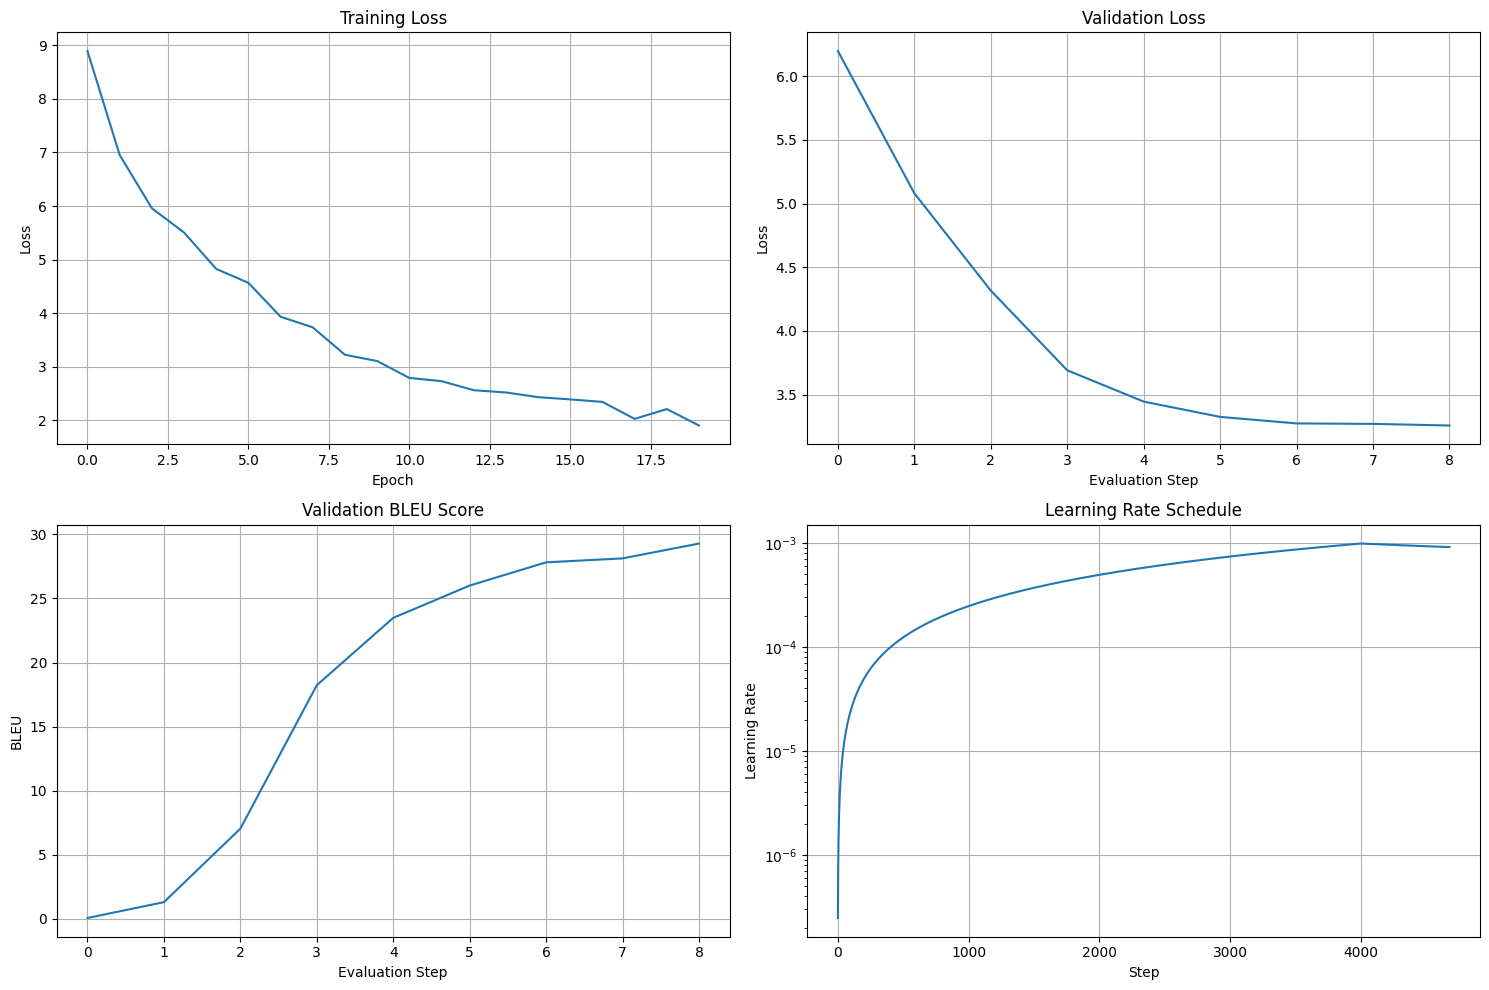

In [21]:
print("Starting training...")
print("-" * 80)

start_time = time.time()

for epoch in range(1, config['epochs'] + 1):
    # training
    model.train()
    epoch_loss = 0.0
    epoch_steps = 0

    for batch_idx, batch in enumerate(train_loader):
        step_start_time = time.time()

        # to device
        src = batch['src'].to(device, non_blocking=True)
        tgt = batch['tgt'].to(device, non_blocking=True)

        # decoder input/output
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        # masks
        tgt_mask = generate_causal_mask(tgt_input.size(1), device)
        tgt_key_padding_mask = (tgt_input == pad_id)
        memory_key_padding_mask = (src == pad_id)

        # reset gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast('cuda'):
            logits = model(
                src,
                tgt_input,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )

            # Compute loss
            B, T, V = logits.size()
            loss = loss_fn(
                logits.reshape(B * T, V),
                tgt_output.reshape(B * T)
            )

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Update statistics
        epoch_loss += loss.item()
        epoch_steps += 1
        global_step += 1

        step_time = time.time() - step_start_time
        training_stats['step_times'].append(step_time)
        training_stats['learning_rates'].append(scheduler.get_last_lr()[0])

        # Print progress
        if batch_idx % 100 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, "
                  f"Loss: {loss.item():.4f}, LR: {current_lr:.2e}, "
                  f"Step time: {step_time:.3f}s")

        # Evaluate periodically
        if global_step % config['eval_every'] == 0:
            print("\n" + "="*50)
            print(f"EVALUATION AT STEP {global_step}")
            print("="*50)

            val_metrics = evaluate(
                model, val_loader, tokenizer, loss_fn,
                pad_id, eos_id, generate_causal_mask, device
            )

            # Log metrics
            training_stats['val_losses'].append(val_metrics['avg_loss'])
            training_stats['val_bleus'].append(val_metrics['bleu'])
            training_stats['val_accuracies'].append(val_metrics['accuracy'])

            print(f"Validation Loss: {val_metrics['avg_loss']:.4f}")
            print(f"Validation Perplexity: {val_metrics['ppl']:.2f}")
            print(f"Token Accuracy: {val_metrics['accuracy']:.2f}%")
            print(f"BLEU Score: {val_metrics['bleu']:.2f}")
            print(f"chrF Score: {val_metrics['chrf']:.2f}")

            # Show sample translations
            print("\nSample Translations:")
            print("-" * 40)
            for i, (pred, ref) in enumerate(zip(val_metrics['sample_preds'][:3],
                                              val_metrics['sample_refs'][:3])):
                print(f"Reference {i+1}: {ref}")
                print(f"Prediction {i+1}: {pred}")
                print()

            # Early stopping check
            if val_metrics['avg_loss'] < best_val_loss:
                best_val_loss = val_metrics['avg_loss']
                best_bleu = val_metrics['bleu']
                patience_counter = 0

                # Save best model
                torch.save({
                    'epoch': epoch,
                    'global_step': global_step,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'val_loss': val_metrics['avg_loss'],
                    'bleu': val_metrics['bleu'],
                    'config': config
                }, 'best_model.pt')

                print(f"✓ New best model saved! BLEU: {best_bleu:.2f}")
            else:
                patience_counter += 1
                print(f"No improvement. Patience: {patience_counter}/{config['patience']}")

            print("="*50 + "\n")

            # Early stopping
            if patience_counter >= config['patience']:
                print(f"Early stopping triggered after {global_step} steps")
                break

    # End of epoch
    avg_train_loss = epoch_loss / epoch_steps
    training_stats['train_losses'].append(avg_train_loss)

    print(f"\nEpoch {epoch} completed. Average training loss: {avg_train_loss:.4f}")

    # Break if early stopping triggered
    if patience_counter >= config['patience']:
        break

# =========================
# TRAINING COMPLETE
# =========================
total_time = time.time() - start_time
avg_step_time = sum(training_stats['step_times']) / len(training_stats['step_times'])

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"Total training time: {total_time/3600:.2f} hours")
print(f"Average step time: {avg_step_time:.3f} seconds")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best BLEU score: {best_bleu:.2f}")
print(f"Total steps: {global_step}")

# Load best model for final evaluation
print("\nLoading best model for final evaluation...")
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Final evaluation on validation set
print("Final validation evaluation:")
final_val_metrics = evaluate(
    model, val_loader, tokenizer, loss_fn,
    pad_id, eos_id, generate_causal_mask, device
)

print(f"Final Validation Loss: {final_val_metrics['avg_loss']:.4f}")
print(f"Final BLEU Score: {final_val_metrics['bleu']:.2f}")
print(f"Final Token Accuracy: {final_val_metrics['accuracy']:.2f}%")

# Plot training curves
plot_training_curves(training_stats)

In [23]:
# Function to test the trained model
def test_model(model, test_sentences, tokenizer, device, max_len=50):
    """Test the model with custom sentences"""
    model.eval()

    pad_id = tokenizer.piece_to_id('<pad>')
    sos_id = tokenizer.piece_to_id('<s>')
    eos_id = tokenizer.piece_to_id('</s>')

    results = []

    with torch.no_grad():
        for sentence in test_sentences:
            # Encode source
            src_ids = tokenizer.encode(sentence, out_type=int)
            src_ids = src_ids[:max_len-2]  # Leave room for padding
            src_ids += [pad_id] * (max_len - len(src_ids))
            src = torch.tensor([src_ids], dtype=torch.long).to(device)

            # Generate translation
            tgt_ids = [sos_id]
            for _ in range(max_len - 1):
                # Prepare decoder input
                tgt_input = tgt_ids + [pad_id] * (max_len - len(tgt_ids))
                tgt_tensor = torch.tensor([tgt_input], dtype=torch.long).to(device)

                # Create masks
                tgt_mask = generate_causal_mask(len(tgt_ids), device)
                memory_key_padding_mask = (src == pad_id)

                # Forward pass
                logits = model(src, tgt_tensor[:, :len(tgt_ids)],
                             tgt_mask=tgt_mask,
                             memory_key_padding_mask=memory_key_padding_mask)

                # Get next token
                next_token = logits[0, -1].argmax().item()
                tgt_ids.append(next_token)

                # Stop at EOS
                if next_token == eos_id:
                    break

            # Decode translation
            translation_ids = [tid for tid in tgt_ids[1:] if tid not in {pad_id, eos_id}]
            translation = tokenizer.decode(translation_ids, out_type=str)

            results.append({
                'source': sentence,
                'translation': translation
            })

    return results

# Test with custom sentences
test_sentences = [
    "Hello, how are you?",
    "I love programming.",
    "The weather is beautiful today.",
    "Can you help me with this problem?",
    "Thank you very much."
]

translations = test_model(model, test_sentences, tokenizer, device)

print("\n" + "="*60)
print("TRANSLATION EXAMPLES")
print("="*60)
for result in translations:
    print(f"English: {result['source']}")
    print(f"Italian: {result['translation']}")
    print("-" * 40)


TRANSLATION EXAMPLES
English: Hello, how are you?
Italian: Ciao, come stai?
----------------------------------------
English: I love programming.
Italian: Io amo la mia.
----------------------------------------
English: The weather is beautiful today.
Italian: Il tempo è bello oggi.
----------------------------------------
English: Can you help me with this problem?
Italian: Può aiutarmi con questo problema?
----------------------------------------
English: Thank you very much.
Italian: Grazie molto.
----------------------------------------
